Задача 8

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
raw_data = open('source_mod.txt').readlines()
raw_data = ' '.join(raw_data)

In [3]:
rus_text = re.sub('[^а-яА-Я.!?]', ' ', raw_data).lower()
data = re.sub('\s+', ' ', rus_text)

In [4]:
sent_data = re.split('[.!?]', data)
sent_data = [x for x in sent_data if x != ' ']
sent_series = pd.Series(sent_data, name='raw_sent')

In [5]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

morph_sent = sent_series.apply(lambda x: " ".join([morph.parse(word)[0].normal_form for word in x.split()])).rename("morph_sent")


In [6]:
from nltk.corpus import stopwords
from stop_words import get_stop_words

nltk_stopwords = stopwords.words('russian')
russian_stopwords = set(get_stop_words('russian'))

for stopwords in nltk_stopwords:
    russian_stopwords.add(stopwords)
    
morph_sent = morph_sent.apply(lambda x: " ".join(x for x in x.split() if x not in russian_stopwords))

In [187]:
df = pd.concat([sent_series, morph_sent], axis=1)
df.shape

(8168, 2)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

X = vect.fit_transform(df['morph_sent'])

In [180]:
from scipy.sparse import vstack
from sklearn.metrics.pairwise import cosine_distances

def err(X, window, values=(1, X.shape[0])): 
    res = np.zeros((X.shape[0], 2))
    for x in range(values[0], values[1]-window-1):
        window_mean = X[x:x+window].mean(axis=0)
        res[x, 0] = cosine_distances(window_mean, X[:x].mean(axis=0))[0]
        res[x, 1] = cosine_distances(window_mean, X[x+window:].mean(axis=0))[0]
    res[:values[0], :] = None
    res[values[1]-window-1:, :] = None
    return res

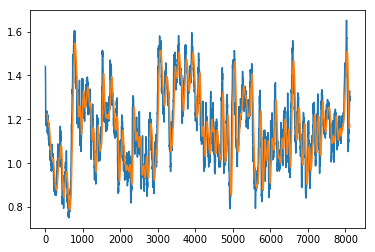

In [181]:
df['sum_err'] = err(X, 50).sum(axis=1)
df['sum_err'].plot()
plt.plot(df['sum_err'].rolling(window=50).mean())

4967

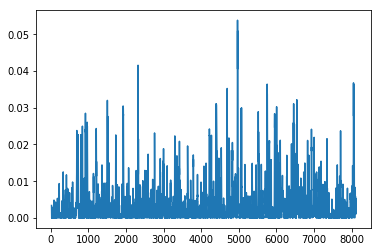

In [176]:
df['approx_err'] = (df['sum_err']-df['sum_err'].rolling(window=20).mean())**2
df['approx_err'].plot()
df['approx_err'].idxmax()

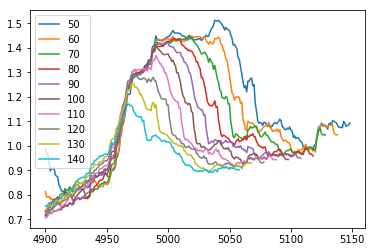

In [177]:
for x in range(50, 150, 10):
    plt.plot(err(X, x, (4900, 5200)).sum(axis=1), label=str(x))
plt.legend()

Необходимо придумать какой-то способ оценивания данного семейства подграфиков, и можно предложить эвристику, заключающуюся в том, что искомым значением является наименьшее значение параметра "окна", удовлетворяющее условию отсутствия некоторого рода "плато" в районе определенного ранее значения(4967), из чего мы можем заключить, что значение параметра равно 100.
(К сожалению, с постановкой конкретной задачи, сводящейся к минимизации и дающей адекватный результат, в этом случае возникли проблемы)

Индексы записей, отвечающих за начало и конец рассказа в датафрейме:

In [179]:
df[df['raw_sent'].str.contains('откровенно говоря|хвораю') == 1]

,raw_sent,morph_sent,rad,err,back_err,sum_err,err_1,err_2,approx_err
4990,откровенно говоря я предпочитаю хворать дома,откровенно говорить предпочитать хворать дом,0.164910,0.690852,0.336601,1.448701,0.690852,0.719955,0.013592
5086,и теперь хвораю дома,хворать дом,0.165174,0.502771,0.706236,1.091126,0.502771,0.461339,0.001512


Таким образом, точность прогноза составила:

In [185]:
acc_score = (np.min((df['approx_err'].idxmax()+100, 5086)) - np.max((df['approx_err'].idxmax(), 4990)))/(5086-4990)

In [186]:
acc_score

0.8020833333333334